In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("./dataset.csv", encoding="ISO-8859-1")
# initial conclusions about data
df.info()
# no missing values
# I'll need to convert weight, ram, fromt cam, back cam, battery capactiy, and screensize into numeric types
# company name, model name, and processor will all need categorical feature preprocessing, probably one hot label encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    object
 14  Launched Y

In [2]:
# PREPROCESSING

# numerical feature conversion for weight, ram, front cam, back cam, battery, screen size, and usd price
# drop unused columns
ppdf = df.drop(['Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (Dubai)'], axis=1)
# there are some decmials so cast weight as float
ppdf['Mobile Weight'] = ppdf['Mobile Weight'].astype(str).str.replace('g', '').astype(float)

# there are some RAM values like 8GB / 12GB (like the Huawei P60 series). we are going to use the first value as that is what the base model uses which is the price listed.
# there are also some decimal values, so we'll cast to float
ppdf['RAM'] = ppdf['RAM'].astype(str).str.split('/').str[0].str.replace('GB', '').astype(float)

# there are some front camera values formatted like 12MP / 4K or 12MP + 12MP so we are just using the first values for now. there is 2 values that starts with 'Dual' which we will test for manually and simply remove the characters
for idx, val in ppdf['Front Camera'].items():
    if val[0] == 'D':
        val = val[5:]
    t = float(val.split('MP')[0])
    ppdf.at[idx, 'Front Camera'] = t

# do the same for back camera
for idx, val in ppdf['Back Camera'].items():
    if val[0] == 'D':
        val = val[5:]
    t = float(val.split('MP')[0])
    ppdf.at[idx, 'Back Camera'] = t

# all values in front camera/back camera are floats now. this next line just tells pandas to recheck the type essentially
ppdf = ppdf.infer_objects()

# for battery capacity we just need to remove the mAh, remove the comma, and cast to int
ppdf['Battery Capacity'] = df['Battery Capacity'].astype(str).str.replace('mAh', '').str.replace(',', '').astype(int)

# for screen size we will split on the first space and cast to float. there are some with external screens (the samsung folds and flips for example) but for now we will just use the first value
ppdf['Screen Size'] = df['Screen Size'].astype(str).str.split(r'\s+').str[0].astype(float)

# for price, just remove the 'USD ' and the comma
ppdf['Launched Price (USA)'] = df['Launched Price (USA)'].astype(str).str.replace('USD ', '').str.replace(',', '').astype(float)

# categorical feature conversion for company, model, and processor. keep a copy of each encoder to unencode values for conclusions
# merge identical company names before converting
ppdf['Company Name'] = ppdf['Company Name'].astype(str).replace('Poco', 'POCO')
companyLE = LabelEncoder()
ppdf['Company Name'] = companyLE.fit_transform(ppdf['Company Name'])

modelLE = LabelEncoder()
ppdf['Model Name'] = modelLE.fit_transform(ppdf['Model Name'])

processorLE = LabelEncoder()
ppdf['Processor'] = processorLE.fit_transform(ppdf['Processor'])

ppdf.info()
#df.head()
ppdf.median(numeric_only=True)
#df.mean(numeric_only=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company Name          930 non-null    int64  
 1   Model Name            930 non-null    int64  
 2   Mobile Weight         930 non-null    float64
 3   RAM                   930 non-null    float64
 4   Front Camera          930 non-null    float64
 5   Back Camera           930 non-null    float64
 6   Processor             930 non-null    int64  
 7   Battery Capacity      930 non-null    int64  
 8   Screen Size           930 non-null    float64
 9   Launched Price (USA)  930 non-null    float64
 10  Launched Year         930 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 80.1 KB


Company Name               9.00
Model Name               449.50
Mobile Weight            194.00
RAM                        8.00
Front Camera              16.00
Back Camera               50.00
Processor                 98.50
Battery Capacity        5000.00
Screen Size                6.67
Launched Price (USA)     449.00
Launched Year           2023.00
dtype: float64

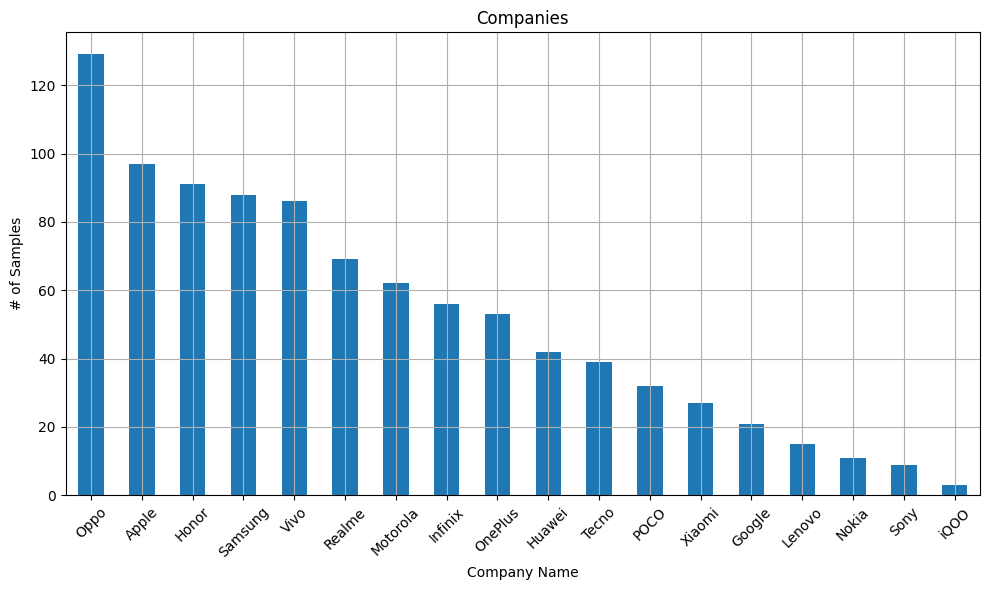

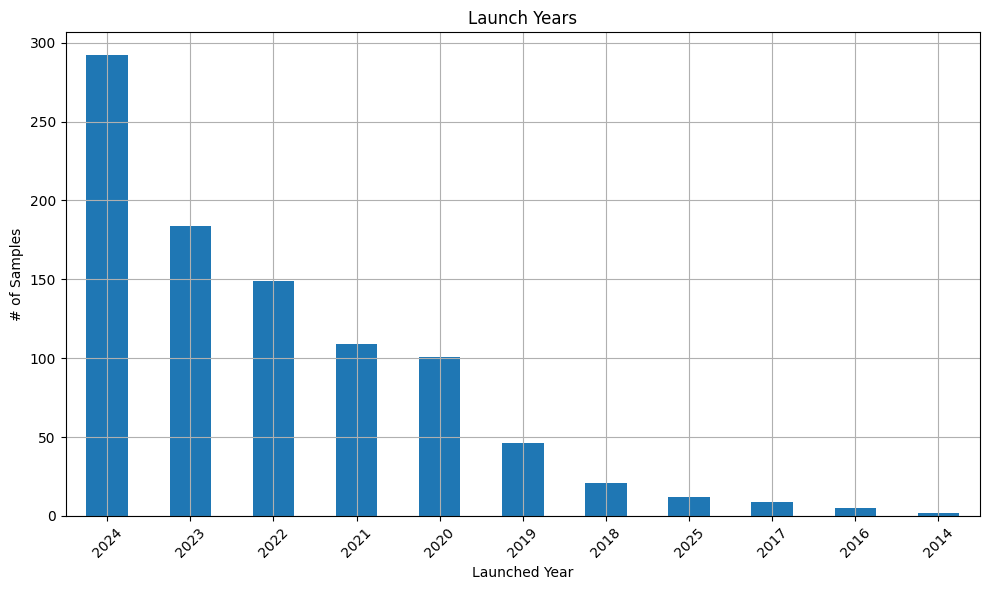

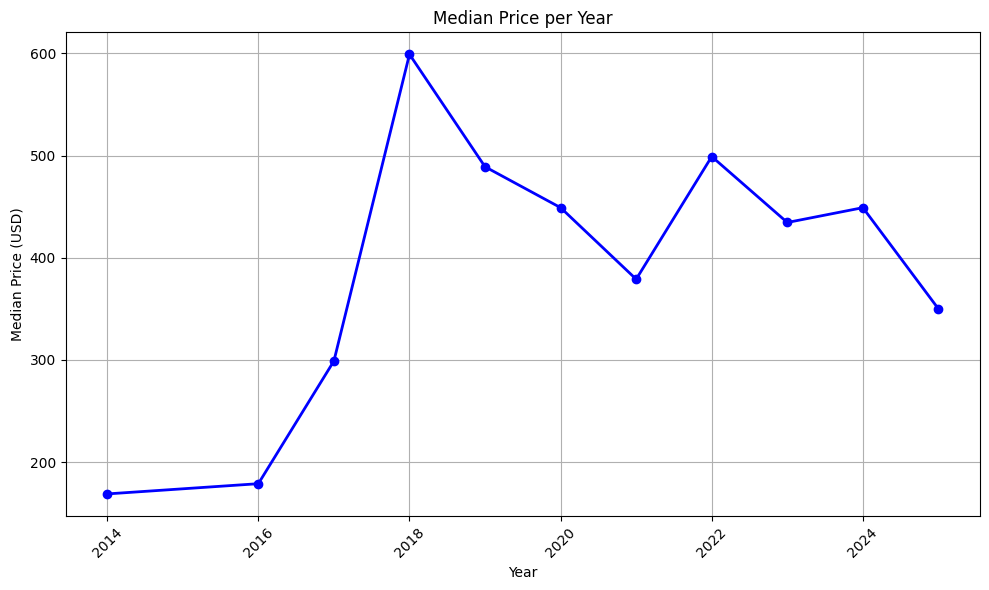

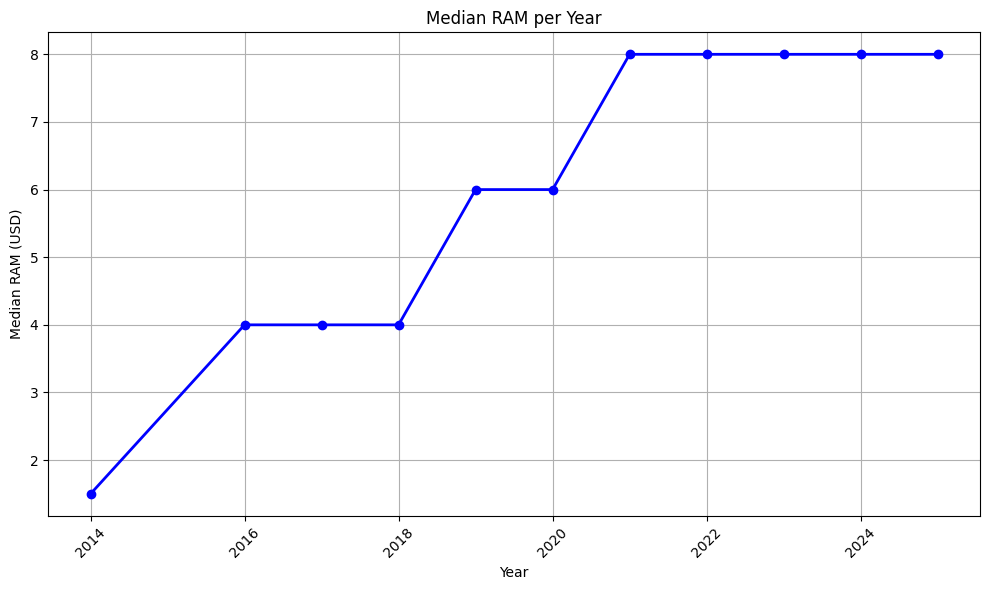

/tmp/ipykernel_513490/728743092.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(shadow=False, scatterpoints=1)


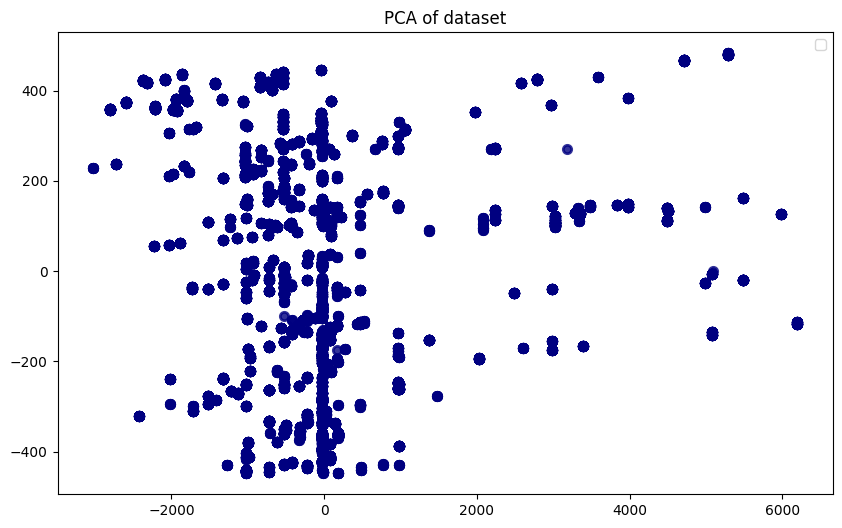

In [3]:
# DATA VISUALIZATION

# replace Poco with POCO since its a missplelling of the same company
df['Company Name'] = df['Company Name'].astype(str).replace('Poco', 'POCO')
plt.figure(figsize=(10,6))
df['Company Name'].value_counts().plot(kind='bar')
plt.title('Companies')
plt.grid(True)
plt.ylabel('# of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Oppo is a Chinese manufacturer and not often seen in US markets.
# It is interesting that they make up the majority of devices in the dataset though.
# Looks like no Samsung A series, which is a few dozen devices, so perhaps it is simply the most complete catalogue.

plt.figure(figsize=(10,6))
df['Launched Year'].value_counts().plot(kind='bar')
plt.title('Launch Years')
plt.grid(True)
plt.ylabel('# of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Many more 2024 devices. Was there an uptick in phones released or simply an imbalancing in the data set?

med_price_per_year = ppdf.groupby('Launched Year')['Launched Price (USA)'].median()
plt.figure(figsize=(10,6))
med_price_per_year.plot(kind='line', marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Median Price per Year')
plt.xlabel('Year')
plt.ylabel('Median Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

med_ram_per_year = ppdf.groupby('Launched Year')['RAM'].median()
plt.figure(figsize=(10,6))
med_ram_per_year.plot(kind='line', marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Median RAM per Year')
plt.xlabel('Year')
plt.ylabel('Median RAM (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# plotting 2d PCA
from sklearn.decomposition import PCA
y = ppdf['Launched Price (USA)']
X = ppdf.drop('Launched Price (USA)', axis=1)
X -= np.mean(X, axis = 0) 

# pca, reduce the number of features to 2
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
plt.figure(figsize=(10,6))
lw = 2
for i in y:
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color='navy', alpha=.8, lw=lw)
plt.legend(shadow=False, scatterpoints=1)
plt.title('PCA of dataset')
plt.show()




In [4]:
# FINDING BEST PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler

# first, find best PCA
best_dim = float('inf')
best_mae = float('inf')
best_mse = float('inf')
best_rmse= float('inf')
for i in range(2, 11):
    pca = PCA(n_components=i)
    X_r = pca.fit(X).transform(X)

    X_train,X_test,y_train,y_test = train_test_split(X_r, 
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)
    
    normalizer = StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    lr = Ridge(alpha=.1)
    lr.fit(X_train, y_train)
        
    y_test_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    if mse < best_mse:
        best_dim = i
        best_mae = mae
        best_mse = mse
        best_rmse = rmse
    print("Dimensions: {:.0f}, MAE: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}".format(i, mae, mse, rmse))

print("Best dimensions was: {:.0f}, with MAE: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}".format(best_dim, best_mae, best_mse, best_rmse))


Dimensions: 2, MAE: 361.6651, MSE: 191279.8570, RMSE: 437.3555
Dimensions: 3, MAE: 372.4668, MSE: 198693.4022, RMSE: 445.7504
Dimensions: 4, MAE: 366.4124, MSE: 203982.7861, RMSE: 451.6445
Dimensions: 5, MAE: 361.6700, MSE: 198679.7761, RMSE: 445.7351
Dimensions: 6, MAE: 359.2787, MSE: 197710.2405, RMSE: 444.6462
Dimensions: 7, MAE: 344.9112, MSE: 186837.9000, RMSE: 432.2475
Dimensions: 8, MAE: 308.1780, MSE: 145515.2791, RMSE: 381.4646
Dimensions: 9, MAE: 308.3143, MSE: 145774.8940, RMSE: 381.8048
Dimensions: 10, MAE: 305.4219, MSE: 147542.5773, RMSE: 384.1127
Best dimensions was: 8, with MAE: 308.1780, MSE: 145515.2791, RMSE: 381.4646


In [5]:
# REGRESSION
# train the model with best PCA from above
pca = PCA(n_components=best_dim)
X_r = pca.fit(X).transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_r, 
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

lr = Ridge(alpha=.1)
lr.fit(X_train, y_train)
        
y_test_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print("MAE: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}".format(mae, mse, rmse))

MAE: 308.1799, MSE: 145522.1696, RMSE: 381.4737
